## License

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Load test analysis

## Initialization

In [0]:
from google.colab import auth
auth.authenticate_user()
project_id = '[your project id]'

## Log Overview

In [0]:
import pandas as pd
df = pd.io.gbq.read_gbq('''
  SELECT
  count(*) as total
FROM
  `web_instr_container.stdout_20200129`
''', project_id=project_id)

total = df.total[0]
print(f'Log records: {total}')

## Client Latency

Text(0, 0.5, 'Median Client Latency (ms)')

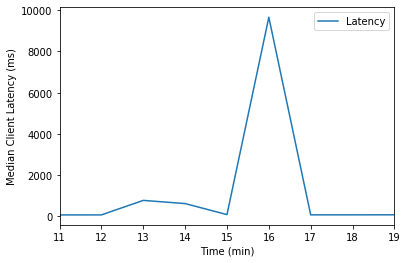

In [0]:
import pandas as pd
df = pd.io.gbq.read_gbq('''
SELECT
  EXTRACT(MINUTE FROM timestamp) AS Minute,
  REGEXP_EXTRACT(textPayload, r"LoadTest: latency: ([0-9]+),") AS Latency
FROM 
  `web_instr_container.stdout_20200129`
WHERE
  EXTRACT(HOUR FROM timestamp) > 10
  AND
  EXTRACT(MINUTE FROM timestamp) > 10
  AND
  EXTRACT(MINUTE FROM timestamp) < 20
ORDER BY
  Minute
''', project_id=project_id)
df1 = df[pd.isnull(df['Latency']) == False]
df1 = df1.astype({'Minute': 'int64', 'Latency': 'int64'})
latency = df1.groupby('Minute').median()
ax = latency.plot()
ax.set_xlabel('Time (min)')
ax.set_ylabel('Median Client Latency (ms)')

## Scatter Plot

Text(0, 0.5, 'Client Latency (ms)')

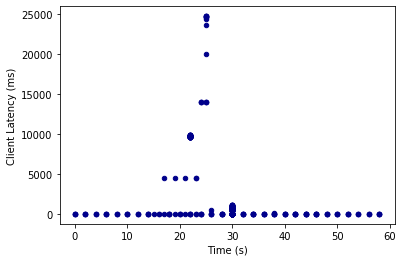

In [0]:
df = pd.io.gbq.read_gbq('''
SELECT
  EXTRACT(SECOND FROM timestamp) AS Seconds,
  REGEXP_EXTRACT(textPayload, r"LoadTest: latency: ([0-9]+),") AS Latency
FROM 
  `web_instr_container.stdout_20200129`
WHERE
  EXTRACT(HOUR FROM timestamp) > 10
  AND
  EXTRACT(MINUTE FROM timestamp) > 14
  AND
  EXTRACT(MINUTE FROM timestamp) < 18
ORDER BY
  Seconds
''', project_id=project_id)
df1 = df[pd.isnull(df['Latency']) == False]
df1 = df1.astype({'Seconds': 'int64', 'Latency': 'int64'})
ax = df1.plot.scatter(x='Seconds', y='Latency', c='DarkBlue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Client Latency (ms)')

## Responses

In [0]:
import pandas as pd
project_id = 'alexamies-alert-demo'
df = pd.io.gbq.read_gbq('''
SELECT
  EXTRACT(MINUTE FROM timestamp) as Minute,
  httpRequest.status AS Status
FROM
   `alexamies-alert-demo.load_balancer_logs.requests_20200124`
GROUP BY
  Minute, Status
ORDER BY Minute, Status
''', project_id=project_id)
df.head(20)

,Minute,Status
0,16,200
1,16,304
2,17,200
